In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import os

2024-04-30 06:44:37.689508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 06:44:37.689681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 06:44:37.843704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
pip install pyyaml h5py 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


# **Formatting the Data:**

In [3]:
#assign the pathway to the kaggle dataset's training folder as the variable "train_folder"
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
#travel through everything in the training data to get the label and path and add it to all_data
for folder in os.listdir(train_folder):
	label_folder = os.path.join(train_folder, folder)
	onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
	all_data += onlyfiles
#create a data frame with all the labels and pathways
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [4]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.25, random_state=42,stratify=x_train[['label']])

# **Model 1 (no data aug):**

In [5]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
	dataframe=x_train,x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
	shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
	dataframe=x_test, x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
	shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
	dataframe=x_holdout, x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
	shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Dense(29, activation = "softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 893,085 (3.41 MB)

 Trainable params: 893,085 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=10

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop],)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 715s 3s/step - accuracy: 0.1204 - loss: 3.0616 - val_accuracy: 0.7632 - val_loss: 0.7224
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 615s 3s/step - accuracy: 0.7970 - loss: 0.6028 - val_accuracy: 0.9542 - val_loss: 0.1551
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - accuracy: 0.9348 - loss: 0.1928 - val_accuracy: 0.9800 - val_loss: 0.0637
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 623s 3s/step - accuracy: 0.9622 - loss: 0.1130 - val_accuracy: 0.9903 - val_loss: 0.0326
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 614s 3s/step - accuracy: 0.9745 - loss: 0.0764 - val_accuracy: 0.9916 - val_loss: 0.0255
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 611s 3s/step - accuracy: 0.9813 - loss: 0.0561 - val_accuracy: 0.9976 - val_loss: 0.0109
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 611s 3s/step - accuracy: 0.9841 - loss: 0.0469 - val_accuracy: 0.9924 - val_loss: 0.0278
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 617s 3s/step - accuracy: 0.9843 - loss: 0.0469 - val_accuracy: 0.997

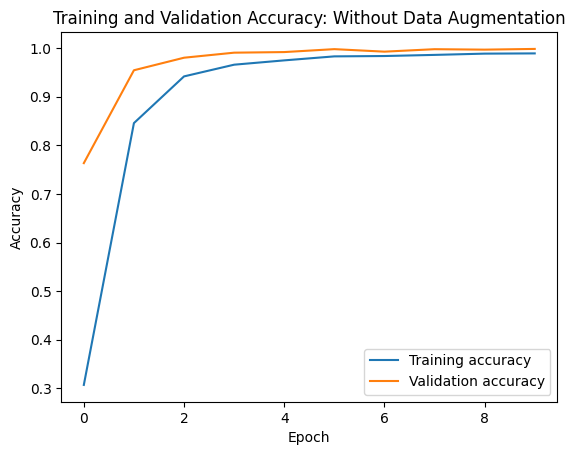

In [9]:
#Plot accuracy 

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy: Without Data Augmentation')
plt.legend()
plt.show()

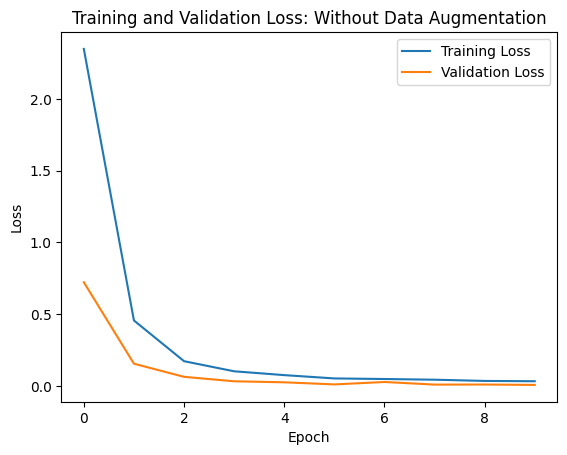

In [10]:
# Plot loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss: Without Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 726ms/step


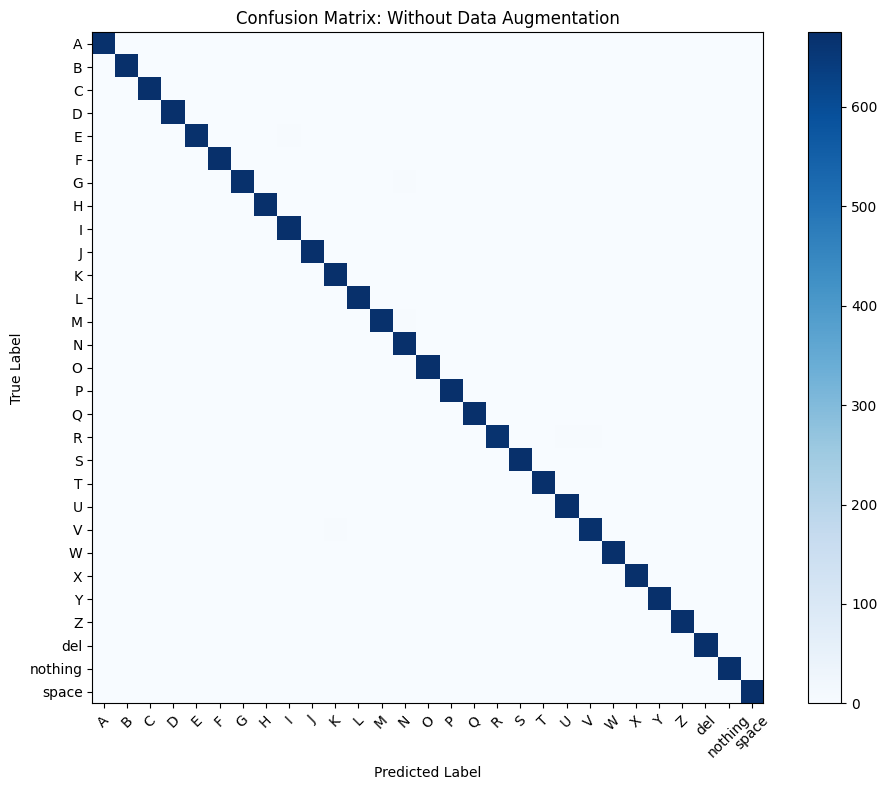

In [11]:
# make a confusion matrix

from sklearn.metrics import confusion_matrix

class_names = list(holdout_generator.class_indices.keys())  

# Generate predictions for the validation dataset
predictions = model.predict(validation_generator)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the validation generator
true_labels = validation_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Without Data Augmentation')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [12]:
model.save_weights('./model_one_weights.weights.h5')

# **Model 2 (with data aug):**

In [13]:
import random 

def augment_data(image):
    
    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        image = tf.image.flip_left_right(image) #flip left right
        
    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        image = tf.image.adjust_saturation(image, 0) #make grayscale
        
    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        rand = random.randint(1, 5)
        image = tf.image.adjust_saturation(image, 5) #adjusts saturation 

    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        rand = random.uniform(0.01, 0.1)
        image = tf.image.adjust_brightness(image, rand) #adjusts brightness

    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        minx = random.randint(10, 70)
        manx = random.randint(80, 100)
        tf.image.random_jpeg_quality(image, minx, manx, seed=None) #adjusts jpeg quality

    if tf.random.uniform((),minval=0,maxval=1) <0.05:
        rand = random.uniform(0.01, 0.05)
        image = tf.image.random_hue(image, rand, seed= None) #adjusts hue 
    
    return image

In [14]:
img_width, img_height = 64, 64
batch_size = 256
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0, preprocessing_function=augment_data) #augements data using function we made

train_generator = train_datagen.flow_from_dataframe(
	dataframe=x_train,x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
	shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
	dataframe=x_test, x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
	shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
	dataframe=x_holdout, x_col=x_col, y_col=y_col,
	target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
	shuffle=False
)

Found 58725 validated image filenames belonging to 29 classes.
Found 19575 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [15]:
aug_model = Sequential()

aug_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
aug_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
aug_model.add(Dropout(0.3))

aug_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
aug_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
aug_model.add(Dropout(0.3))

aug_model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
aug_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
aug_model.add(Dropout(0.3))

aug_model.add(Conv2D(filters = 128, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
aug_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

aug_model.add(Flatten())
aug_model.add(Dense(256))
aug_model.add(Dense(29, activation = "softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:
aug_model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
aug_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 893,085 (3.41 MB)

 Trainable params: 893,085 (3.41 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

batch_size=128
epochs=10

aug_history = aug_model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks = [early_stop],)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


230/230 ━━━━━━━━━━━━━━━━━━━━ 651s 3s/step - accuracy: 0.1759 - loss: 2.8745 - val_accuracy: 0.8166 - val_loss: 0.6033
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 649s 3s/step - accuracy: 0.7897 - loss: 0.6819 - val_accuracy: 0.9591 - val_loss: 0.1456
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 651s 3s/step - accuracy: 0.9031 - loss: 0.3080 - val_accuracy: 0.9738 - val_loss: 0.0844
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - accuracy: 0.9376 - loss: 0.2002 - val_accuracy: 0.9833 - val_loss: 0.0630
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 688s 3s/step - accuracy: 0.9529 - loss: 0.1473 - val_accuracy: 0.9946 - val_loss: 0.0269
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 651s 3s/step - accuracy: 0.9606 - loss: 0.1246 - val_accuracy: 0.9957 - val_loss: 0.0205
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 649s 3s/step - accuracy: 0.9640 - loss: 0.1100 - val_accuracy: 0.9957 - val_loss: 0.0163
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.9702 - loss: 0.0938 - val_accuracy: 0.994

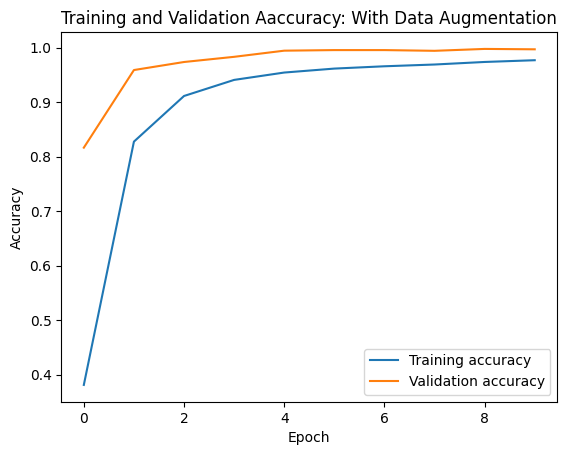

In [18]:
#Plot accuracy 

plt.plot(aug_history.history['accuracy'], label='Training accuracy')
plt.plot(aug_history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Aaccuracy: With Data Augmentation')
plt.legend()
plt.show()

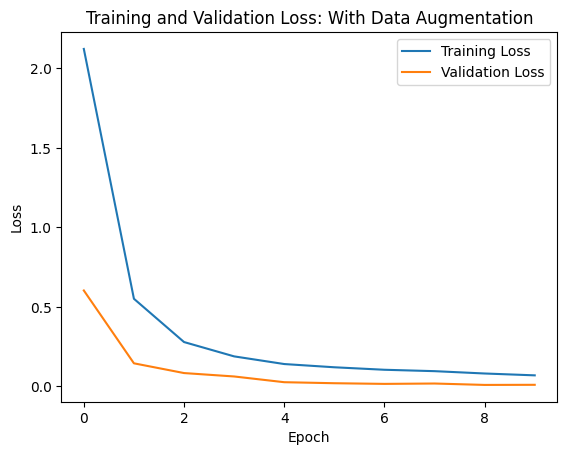

In [19]:
#plot loss

plt.plot(aug_history.history['loss'], label='Training Loss')
plt.plot(aug_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss: With Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

77/77 ━━━━━━━━━━━━━━━━━━━━ 57s 730ms/step


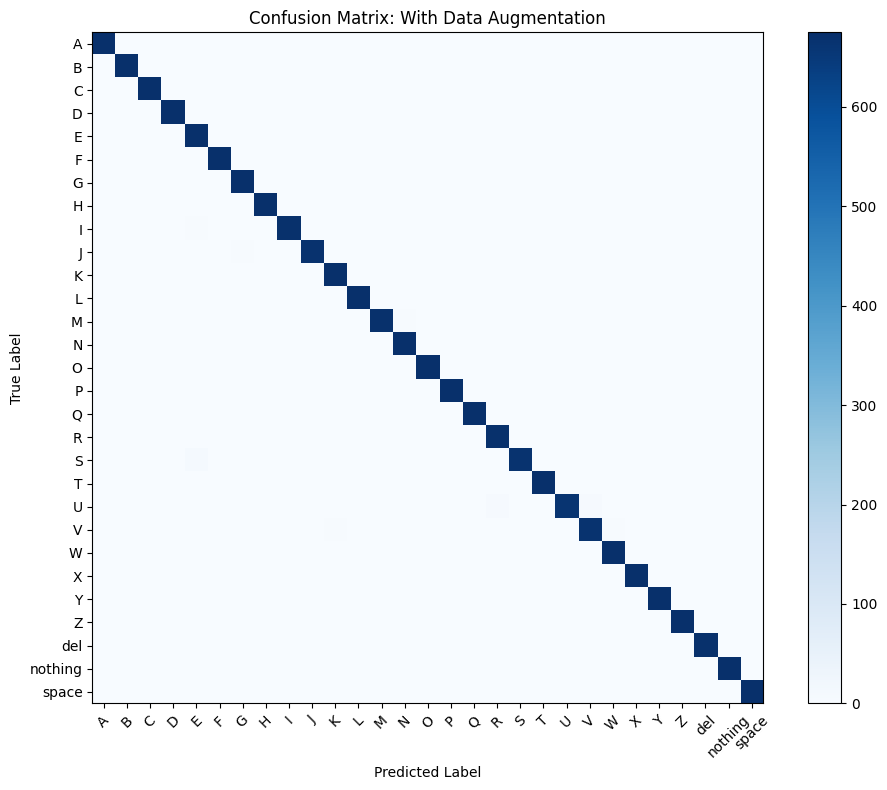

In [20]:
class_names = list(holdout_generator.class_indices.keys())  

# Generate predictions for the validation dataset
predictions = aug_model.predict(validation_generator)

# Convert predictions from probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the validation generator
true_labels = validation_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix: With Data Augmentation')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [21]:
aug_model.save_weights('./aug_model_weights.weights.h5')